In [15]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [16]:
# dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
# download_url(dataset_url, '.')

In [17]:
# Extract from archive
# with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
#     tar.extractall(path='./data')

In [18]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [19]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

In [20]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [21]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [22]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [23]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [24]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  frog (6)


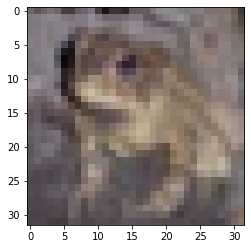

In [25]:
import numpy as np
show_example(*dataset[np.random.randint(len(dataset))])

In [26]:
from torch.utils.data.dataloader import DataLoader

batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [27]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

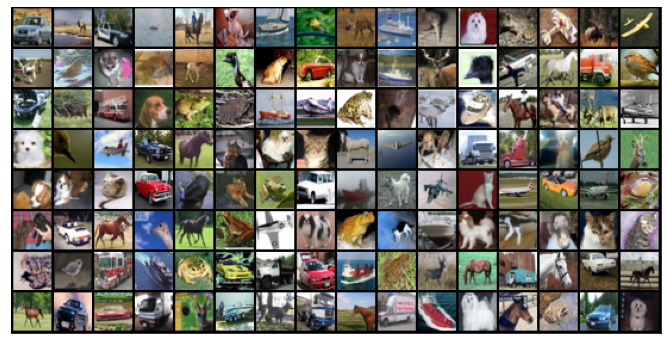

In [28]:
show_batch(train_dl)

The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif">

In [29]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [30]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

There are certain advantages offered by convolutional layers when working with image data:

 - Fewer parameters: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer.
 - Sparsity of connections: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
 - Parameter sharing and spatial invariance: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a max-pooling layers to progressively decrease the height & width of the output tensors from each convolutional layer.
<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png">

In [31]:
import torch.nn as nn
import torch.nn.functional as F

simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),   # 3 canali 8 filtri?
    nn.MaxPool2d(2, 2)
)

In [32]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


Parto con 128 immagini con 3 canali 32 x 32. Applico conv layer e ottengo 128 immagini con 8 canali 32 x 32 siccome padding=1 e kernel_size=3. Infine applico maxpool 2x2 e dimezzo la dimensione di ogni canale, quindi 128 immagini per 8 canali 16 x 16

The Conv2d layer transforms a 3-channel image to a 8-channel feature map, and the MaxPool2d layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [34]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [35]:
model = Cifar10CnnModel()
model
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0311,  0.0233,  0.0208, -0.0262, -0.0280,  0.0242,  0.0458, -0.0277,
         0.0221, -0.0314], grad_fn=<SelectBackward>)


In [36]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [37]:
device = get_default_device()
device

device(type='cpu')

In [38]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [39]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()   # model in evaluation mode
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [40]:
model = to_device(Cifar10CnnModel(), device)
evaluate(model, val_dl)

num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.01

In [41]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 3.4269, val_loss: 2.3040, val_acc: 0.0945
Epoch [1], train_loss: 2.3034, val_loss: 2.3030, val_acc: 0.0964
Epoch [2], train_loss: 2.3033, val_loss: 2.3036, val_acc: 0.0965
